In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.optimize import fsolve
from typing import Callable
from numpy.typing import NDArray

sns.set_theme(context='notebook', style="white")
sns.set_palette("colorblind", color_codes=True)
sns.set_style("whitegrid")

In [ ]:
def lorenz(state, sigma=10, rho=28, beta=8/3) -> NDArray:
    """ Computes the derivatives [dx/dt, dy/dt, dz/dt] for one step of the Lorenz system.

    Parameters
    ----------
    state : array-like, shape (3,)
        Starting point vector in 3-dimensional R space. 
        expands into a tuple (x, y, z)
    sigma, rho, beta : float
        Parameters defining the Lorenz attractor. 
        Defaults: 10, 28, 8/3

    Returns
    -------
    xyz_dot : array-like, shape (3,)
        Values of the Lorenz attractor's partial derivatives at (x, y, z).
    """
    x, y, z = state
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return np.array([x_dot, y_dot, z_dot])

Here we have a few other interesting attractors. The Rossler attractor is a good simple attractor that gives an interesting simplified look at the underlying structure of a strange attractor without the added complexity of symmetrical nodes.

In [8]:
def rossler(state, alpha=0.21, beta=0.2, gamma=5.5) -> NDArray:
    x, y, z = state
    x_dot = - y - z
    y_dot = x + alpha * y
    z_dot = beta + z*(x - gamma)
    return np.array([x_dot, y_dot, z_dot])

In [6]:
def aizawa(state, alpha=0.95, beta=0.7, gamma=0.6, delta=3.5, epsilon=0.25, zeta=0.1) -> NDArray:
    """ Computes the derivatives [dx/dt, dy/dt, dz/dt] for the Aizawa / Langford system.

    Parameters
    ----------
    state : array-like, shape (3,)
       Starting point vector in 3-dimensional R space. expands into a tuple (x, y, z)
    """
    x, y, z = state
    x_dot = (z - beta) * x - delta * y
    y_dot = delta * x + (z - beta) * y
    z_dot = gamma + alpha * z - (z**3 / 3) \
          - (x**2 + y**2)*(1 + epsilon * z) \
          + zeta * z * x**3
    return np.array([x_dot, y_dot, z_dot])

In [7]:
def wang_sun(state, alpha=0.2, beta=-0.01, gamma=1, delta=-0.4, epsilon=-1, zeta=-1) -> NDArray:
    x, y, z = state
    x_dot = alpha * x + gamma * y * z
    y_dot = beta * x + delta * y - (x * z)
    z_dot = (epsilon * z) + (zeta * x * y)
    return np.array([x_dot, y_dot, z_dot])

In [ ]:
def euler_step(state, attractor: Callable[..., NDArray], dt: float, type: str = 'explicit') -> NDArray:
    """ Performs one step of Forward Euler integration.
    math:: y_{n+1} = y_{n} + f(y_{n}) * dt

    Parameters
    ----------
    state : array-like
        The state of the function to be approximated. 
        Can be an array, a tuple, or a singular value.
    attractor : Callable
    dt : float
        The time step to be evaluated. 

    Returns
    -------
    y_{n+1} : NDArray
    """
    # I don't actually know if this implementation works.
    # The idea was to do both forward and backward euler in the same function. 
    # I didn't try to debug it...
    if type == 'implicit':
        residual = lambda state_plus_1 : state_plus_1 - state - dt * attractor(state_plus_1)
        # fsolve returns a tuple so just grab the first element.
        state_next, _ = fsolve(residual, state)
        return state_next
    return state + attractor(state) * dt


def rk4_step(state, attractor: Callable[..., NDArray], dt: float = 0.01):
    """Performs one step of Runge-Kutta 4 integration.

    The Runge-Kutta approximation method is much more accurate than 
    Euler for the same time step.

    Parameters 
    ----------
    state : array-like
        Should be an NDArray or array-like that returns a vector of coordinates of 
        the phase space.
    attractor : Callable[..., NDArray]
        passes in a function to be run which takes some values and returns an NDArray.
    dt : float
        time step. defaults to 0.01.
    """
    k1 = attractor(state)
    k2 = attractor(state + k1 * dt / 2)
    k3 = attractor(state + k2 * dt / 2)
    k4 = attractor(state + k3 * dt)
    
    # Weighted average of the slopes
    return state + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6

In [ ]:
# Showcases intuitively why RK4 is better for numerical approximations:
# https://www.youtube.com/watch?v=dShtlMl69kY

dt = 0.01
num_steps = 5000
initial_state = np.array([1.0, 1.0, 1.0])
t = np.arange(0.0, 50.0, dt)

# Initialize arrays to store trajectories
# Shape is (num_steps, 3) for x, y, z coordinates
trajectory_euler = np.zeros((num_steps, 3))
trajectory_rk4 = np.zeros((num_steps, 3))
trajectory_rk4_perturbed = np.zeros((num_steps, 3))

# Set initial conditions
trajectory_euler[0] = initial_state
trajectory_rk4[0] = initial_state
trajectory_rk4_perturbed[0] = initial_state + [(0.0, 0.0, 1e-9)]

# Trying both rk4 and euler methods for numerical simulations of the lorenz attractor.
# Update the paths for each generated attractor.
for i in range(num_steps - 1):
    trajectory_euler[i+1] = euler_step(trajectory_euler[i], lorenz, dt)
    trajectory_rk4[i+1] = rk4_step(trajectory_rk4[i], lorenz, dt)
    trajectory_rk4_perturbed[i+1] = rk4_step(trajectory_rk4_perturbed[i], lorenz, dt)


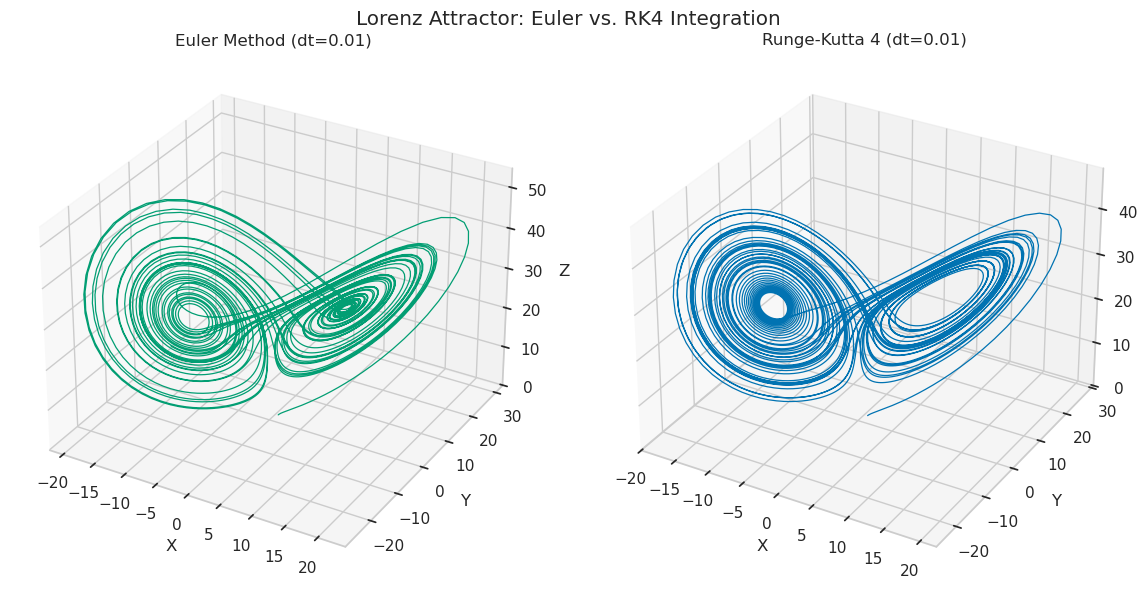

In [ ]:
# Plotting
fig = plt.figure(figsize=(12, 6))

# Euler
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(trajectory_euler[:, 0], trajectory_euler[:, 1], trajectory_euler[:, 2], color='g', lw=0.9)
ax1.set_title(f'Euler Method (dt={dt})')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')

# RK4
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(trajectory_rk4[:, 0], trajectory_rk4[:, 1], trajectory_rk4[:, 2], color='b', lw=0.9)
ax2.set_title(f'Runge-Kutta 4 (dt={dt})')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')

plt.suptitle("Lorenz Attractor: Euler vs. RK4 Integration")
plt.tight_layout()
plt.show()

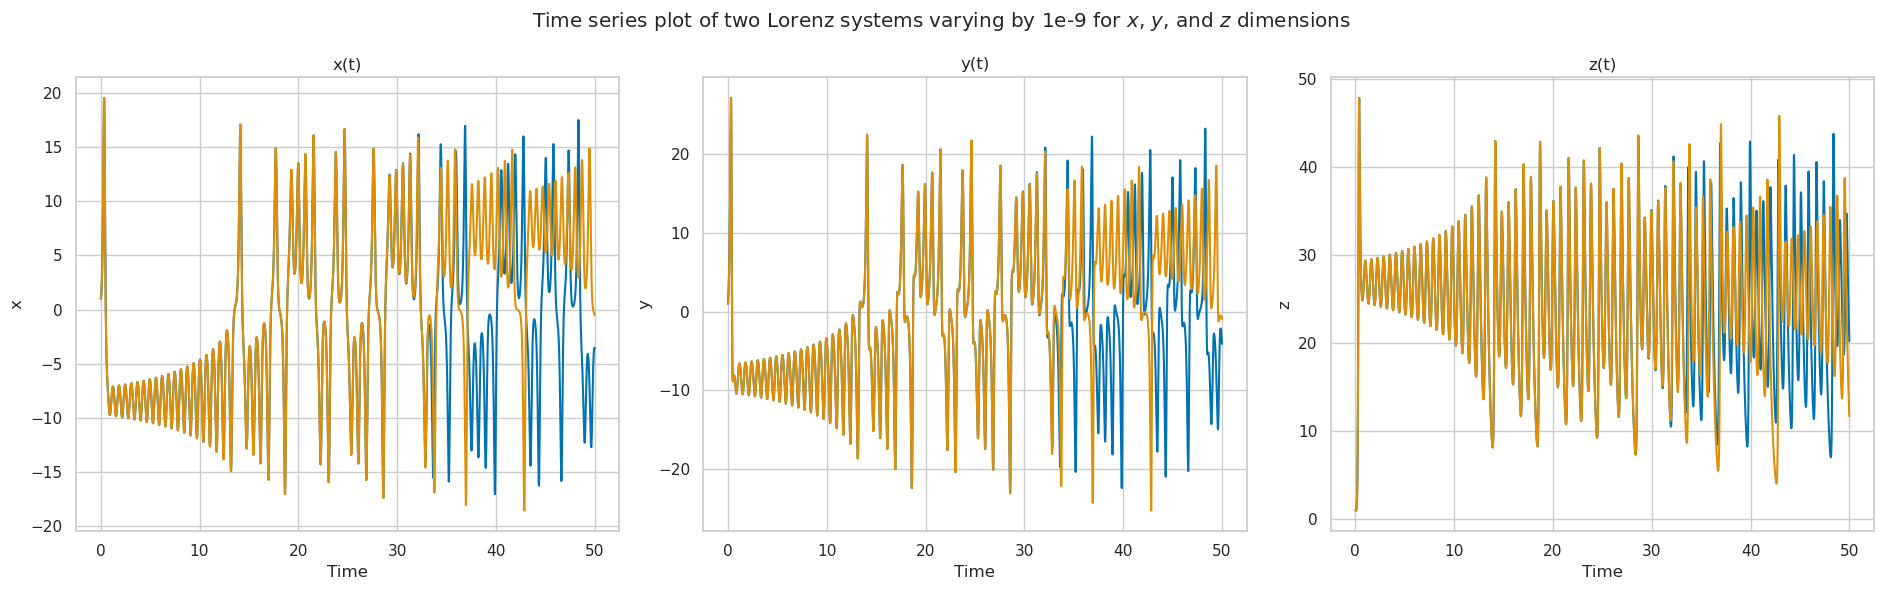

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(19, 6), sharex=True)

axes[0].plot(t, trajectory_rk4[:, 0])
axes[0].plot(t, trajectory_rk4_perturbed[:, 0])
axes[0].set_title('x(t)')
axes[0].set_ylabel('x')
axes[0].set_xlabel('Time')

axes[1].plot(t, trajectory_rk4[:, 1])
axes[1].plot(t, trajectory_rk4_perturbed[:, 1])
axes[1].set_title('y(t)')
axes[1].set_ylabel('y')
axes[1].set_xlabel('Time')

axes[2].plot(t, trajectory_rk4[:, 2])
axes[2].plot(t, trajectory_rk4_perturbed[:, 2])
axes[2].set_title('z(t)')
axes[2].set_ylabel('z')
axes[2].set_xlabel('Time')

plt.suptitle("Time series plot of two Lorenz systems varying by 1e-9 for $x$, $y$, and $z$ dimensions")
plt.tight_layout()

Text(0.5, 0, 'Z')

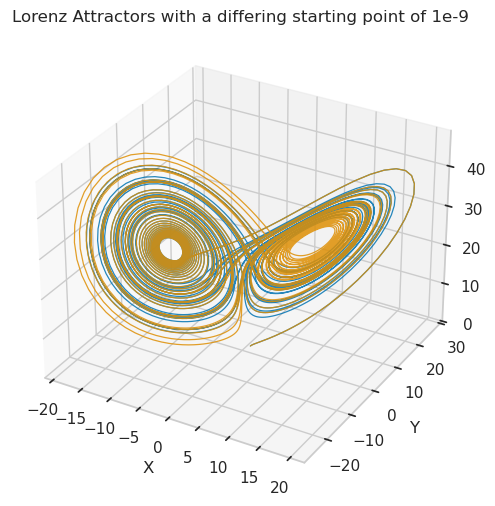

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot(trajectory_rk4[:, 0], trajectory_rk4[:, 1], trajectory_rk4[:, 2], alpha=0.85, lw=0.9)
ax.plot(trajectory_rk4_perturbed[:, 0], trajectory_rk4_perturbed[:, 1], trajectory_rk4_perturbed[:, 2], alpha=0.85, lw=0.9)
ax.set_title(f'Lorenz Attractors with a differing starting point of 1e-9')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

Calculated MLE: 0.9046
Target MLE:     0.9056


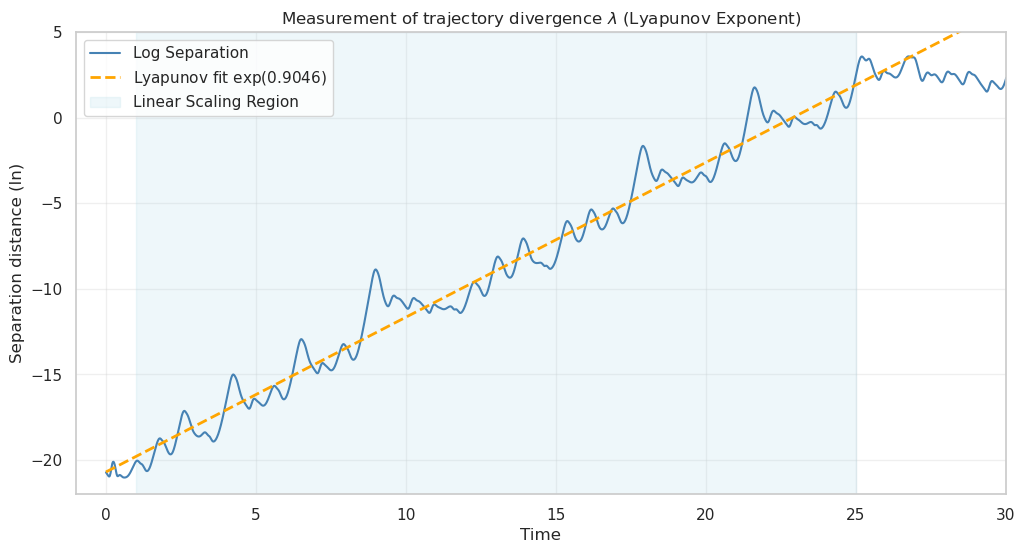

In [ ]:
num_steps = 4000
initial_state = np.array([2.0, 3.0, -14.0]) 
perturbed_state = initial_state + np.array([0.0, 0.0, 1e-9]) 

time = np.zeros(num_steps)
log_separation = np.zeros(num_steps)

for i in range(num_steps):
    log_separation[i] = np.log(np.linalg.norm(initial_state - perturbed_state))
    time[i] = (i * dt)

    initial_state = rk4_step(initial_state, lorenz, dt)
    perturbed_state = rk4_step(perturbed_state, lorenz, dt)

# Calculate Slope (Lyapunov Exponent)
# Fit the line only in the "linear scaling region" 
# (e.g., between t=1 and t=25) before saturation occurs.
start_idx = int((lin_min := 1) / dt)
end_idx = int((lin_max := 25) / dt)

slope, intercept = np.polyfit(time[start_idx:end_idx], log_separation[start_idx:end_idx], 1)

print(f"Calculated MLE: {slope:.4f}")
print(f"Target MLE:     0.9056")


plt.figure(figsize=(12, 6))
plt.plot(time, log_separation, label='Log Separation', color='steelblue')
fit_line = slope * np.array(time) + intercept
plt.plot(time, fit_line, '--', color='orange', label=f'Lyapunov fit $\\exp({slope:.4f})$', lw=2)

plt.axvspan(lin_min, lin_max, color='lightblue', alpha=0.2, label='Linear Scaling Region')
plt.xlabel('Time')
plt.xlim((-1, 30))
plt.ylim((-22, 5))
plt.ylabel('Separation distance (ln)')
plt.title('Measurement of trajectory divergence $\\lambda$ (Lyapunov Exponent)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

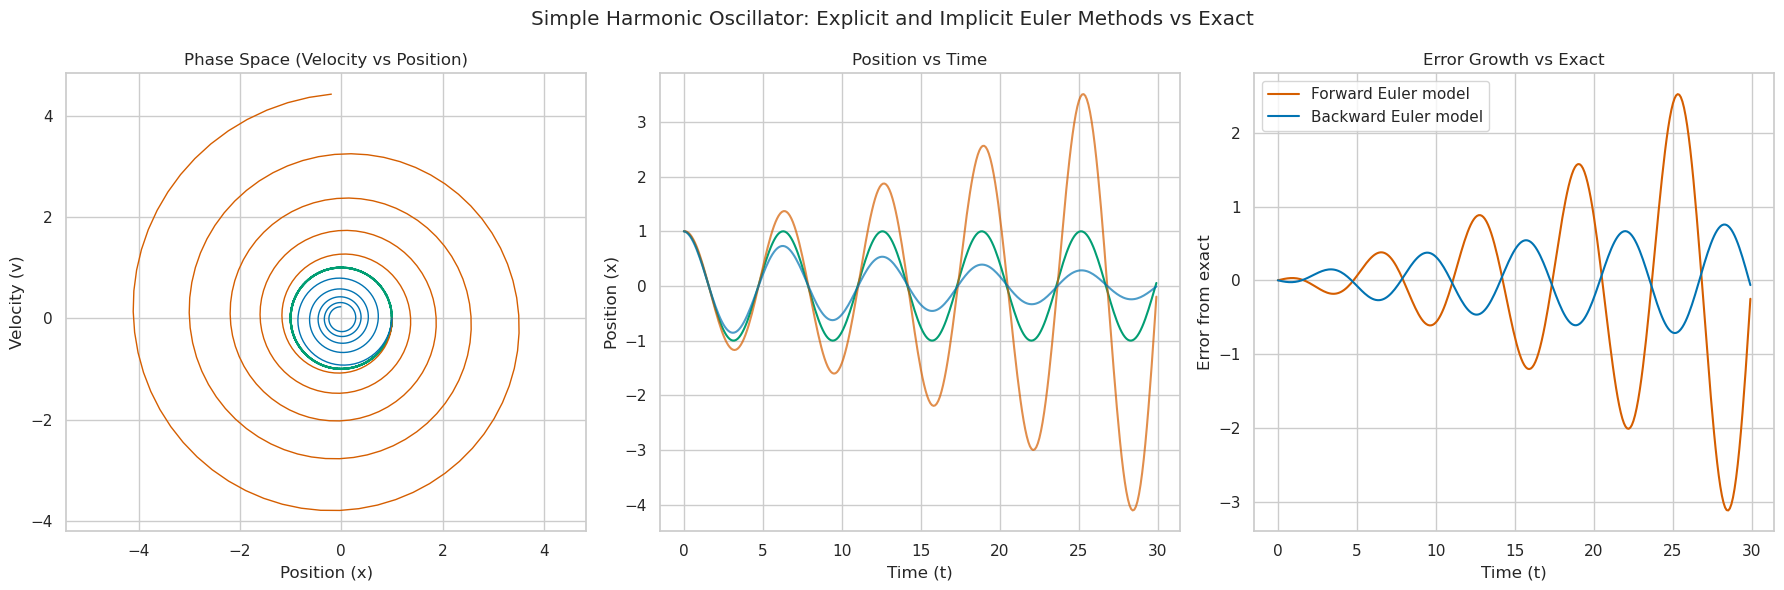

In [ ]:
# I was hoping I could do this one similarly to the attractors.
# I think this doesn't work because it is explicitly dependent 
# on time, unlike the attractor models.
def sho(x, v, dt, omega=1.0) -> NDArray:
   x_dot = x + dt * v
   v_dot = v - dt * omega * x
   return np.array([x_dot, v_dot])

def simple_harmonic_oscillator(omega=1.0, dt=0.1, num_steps=30, plot=True) -> None:
    """ 
    This is a good example of numerical compounding error 
    compared to the strange attractors as the exact solution for
    the simple harmonic oscillator is known.
    math:: 
        x(t) = x_0 \\cos{(\\omega t)} + (v_0/\\omega) \\sin(\\omega t) \\
        v(t) = -x_0 \\omega \\sin(\\omega t) + v_0 \\cos(\\omega t)

    Parameters
    ----------
    omega : float
    dt : float
    num_steps : int 
    plot : bool
    
    Returns
    -------
    None

    """     
    # initial conditions
    x_0, v_0 = 1.0, 0.0
    t = np.arange(0, num_steps, dt)

    x_forward, v_forward = np.zeros(len(t)), np.zeros(len(t))
    x_backward, v_backward = np.zeros(len(t)), np.zeros(len(t))
    x_exact, v_exact = np.zeros(len(t)), np.zeros(len(t))

    x_forward[0] = x_backward[0] = x_exact[0] = x_0
    v_forward[0] = v_backward[0] = v_exact[0] = v_0

    for i in range(len(t) - 1):
        # Stole this from https://stackoverflow.com/questions/70794806/
        # x_new = x + dt * v
        # v_new = v - dt * omega**2 * x
        x_forward[i+1] = x_forward[i] + dt * v_forward[i]
        v_forward[i+1] = v_forward[i] - dt * omega**2 * x_forward[i]
        
        # System: y' = Ay. Backwards: y_{n+1} = (I - h*A)**(-1) y_n
        # https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/02_TimeIntegration/02_01_EulerMethod.html#equation-eq-back-stab
        # Matrix form derivation leads to dividing by (1 + (dt * \\omega)**2)
        x_backward[i+1] = (x_backward[i] + dt * v_backward[i]) / (1 + (dt * omega)**2)
        v_backward[i+1] = (v_backward[i] - dt * (omega**2) * x_backward[i]) / (1 + (dt * omega)**2)
        
        t_next = t[i+1]
        x_exact[i+1] =  x_0 * np.cos(omega * t_next) + (v_0 / omega) * np.sin(omega * t_next)
        v_exact[i+1] = -x_0 * omega * np.sin(omega * t_next) + v_0 * np.cos(omega * t_next)

    if plot == True:
        # Plotting
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # phase space
        axes[0].plot(x_exact, v_exact, 'g--', linewidth=1.5, label='Exact (Energy Conserved)')
        axes[0].plot(x_forward, v_forward, 'r-', linewidth=1.0, label='Forward Euler (Energy Increases)')
        axes[0].plot(x_backward, v_backward, 'b-', linewidth=1.0, label='Backward Euler (Energy Decreases)')
        axes[0].set_title('Phase Space (Velocity vs Position)')
        axes[0].set_xlabel('Position (x)')
        axes[0].set_ylabel('Velocity (v)')
        axes[0].axis('equal')
            
        # time series
        axes[1].plot(t, x_exact, 'g-', label='Exact')
        axes[1].plot(t, x_forward, 'r-', alpha=0.7, label='Forward')
        axes[1].plot(t, x_backward, 'b-', alpha=0.7, label='Backward')
        axes[1].set_title('Position vs Time')
        axes[1].set_xlabel('Time (t)')
        axes[1].set_ylabel('Position (x)')
            
        # literal difference/error
        axes[2].plot(t, x_forward - x_exact, 'r-', label='Forward Euler model')
        axes[2].plot(t, x_backward - x_exact, 'b-', label='Backward Euler model')
        axes[2].set_title('Error Growth vs Exact')
        axes[2].set_xlabel('Time (t)')
        axes[2].set_ylabel('Error from exact')
        axes[2].legend()
            
        plt.suptitle("Simple Harmonic Oscillator: Explicit and Implicit Euler Methods vs Exact")
        plt.tight_layout()
        # plt.savefig('euler_comparison.png')

simple_harmonic_oscillator()

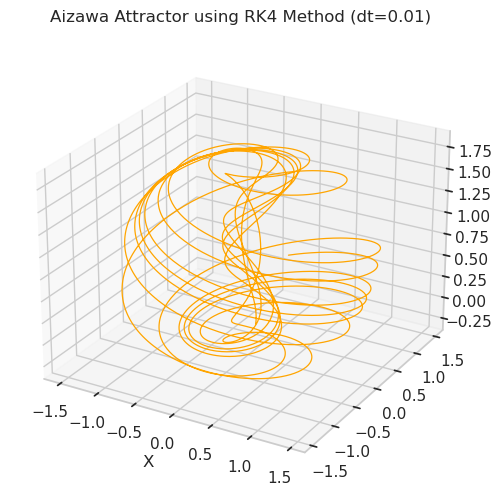

In [14]:
aizawa_rk4 = np.zeros((num_steps, 3))
aizawa_rk4[0] = np.array([0.1, 0.0, 0.0])

for i in range(num_steps - 1):
    aizawa_rk4[i+1] = rk4_step(aizawa_rk4[i], aizawa, dt)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot(aizawa_rk4[:, 0], aizawa_rk4[:, 1], aizawa_rk4[:, 2], color='orange', lw=0.9)
ax.set_title(f'Aizawa Attractor using RK4 Method (dt={dt})')
ax.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
# Set a nice viewing angle to see the "vortex tube" structure
ax.view_init(elev=25, azim=-60)

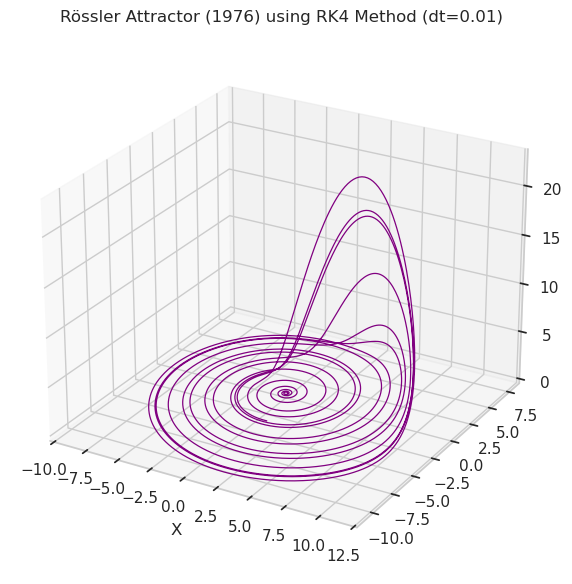

In [15]:
# the Rossler Attractor
rossler_rk4 = np.zeros((num_steps := 10000, 3))
rossler_rk4[0] = np.array([0.1, 0.0, 0.0])
for i in range(num_steps - 1):
    rossler_rk4[i+1] = rk4_step(rossler_rk4[i], rossler, dt)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot(rossler_rk4[:, 0], rossler_rk4[:, 1], rossler_rk4[:, 2], color='purple', lw=0.9)
ax.set_title(u'Rössler Attractor (1976) ' +  f'using RK4 Method (dt={dt})')
ax.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax.view_init(elev=25, azim=-60)
plt.tight_layout()
# plt.close(fig)

In [16]:
num_steps = 100000
wang_sun_rk4 = np.zeros((num_steps, 3))
# These starting positions are what is used in Wang-Sun (2008). 
wang_sun_rk4[0] = np.array([0.5, 0.1, 0.1])

for i in range(num_steps - 1):
    wang_sun_rk4[i+1] = rk4_step(wang_sun_rk4[i], wang_sun, dt)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot(wang_sun_rk4[:, 0], wang_sun_rk4[:, 1], wang_sun_rk4[:, 2], color='crimson', lw=0.9)
ax.set_title(f'Wang-Sun Attractor (2008) using RK4 Method (dt={dt})')
ax.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax.view_init(elev=25, azim=-60)
plt.tight_layout()
plt.close(fig)

In [33]:
fig = px.line_3d(x=wang_sun_rk4[:, 0], y=wang_sun_rk4[:, 1], z=wang_sun_rk4[:, 2])
fig.show()
fig.savefig('wang_sun_plotly.png')

AttributeError: 'Figure' object has no attribute 'savefig'